In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
import sqlite3
# from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
# import sys
# reload(sys)
# sys.setdefaultencoding('utf8')

In [2]:
cd ..

/Users/gstudent/Desktop


# Loading the Data and EDA

## Data Pipeline to Save CSV:

In [ ]:
#connect to databse
conn = sqlite3.connect("../pitchfork-data/pitchfork.db")
#create dataframes for each table
df = pd.read_sql_query("select * from reviews;", conn)
df_reviews = pd.read_sql_query("select * from content", conn)
df_years = pd.read_sql_query("select * from years;", conn)
df_genres = pd.read_sql_query("select * from genres", conn)
#create dummies to allow for multiple genres for each review
df_genres = pd.get_dummies(df_genres, columns=['genre']).groupby('reviewid').sum().reset_index()


In [ ]:
#merge tables
df = df.merge(df_years)
df = df.merge(df_genres)
df = df.merge(df_reviews).reset_index()


df.year.fillna(value=df.pub_year, inplace=True)
df.drop_duplicates('reviewid',inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.drop('author_type', axis=1, inplace=True)
df.year = df.year.astype(int)
df = df[df['pub_year'] < 2018]

# Feature Engineering

In [ ]:
#Reviews containing the following words are reissued albums
list_of_words = ['reissue', 'remaster', 'box set', 'collector', 'delux']

def parse_content_for_reissue(df, list_of_words):
    df['reissue'] = 0
    for each in list_of_words:
        df['reissue'] = df['reissue'] + df['content'].str.contains(each).astype('int')
    df['reissue'] = df['reissue'].astype(bool).astype(int)

parse_content_for_reissue(df, list_of_words)

In [ ]:
df['first100'] = df['content'].str[0:1000]

In [ ]:
df['first100'].str.contains('reissue').sum()

In [ ]:
df['content'].str.contains('reissue').sum()

In [ ]:
#Reviews that were reviewed years after their release are classic albums
df['num_years_since_release'] = df.pub_year - df.year

df['new_album'] = ((df['reissue'] == 0) & (df['num_years_since_release'] <= 1)).astype(int)

In [ ]:
df['year-month'] = df['pub_date'].str[0:7]

In [ ]:
df.reset_index(inplace=True)

In [ ]:
def f(string):
    return re.sub('[^A-Za-z0-9]+', ' ', string)

df['content_stripped'] = df['content'].map(f)

In [ ]:
#Adding Sentiment Scores with TextBlob. This will come in handy later.

sentiments = []
for each in range(len(df['reviewid'])):
    sentiments.append((df['reviewid'].iloc[each], TextBlob(df['content_stripped'][each]).sentiment[0], TextBlob(df['content_stripped'][each]).sentiment[1]))
#                           TextBlob(df_mid['content'][each], analyzer=NaiveBayesAnalyzer()).sentiment))

df_sent = pd.DataFrame(sentiments, columns=['reviewid', 'polarity', 'subjectivity'])

In [ ]:
df = df.merge(df_sent)

In [ ]:
df.drop('year-month', axis=1, inplace=True)

In [ ]:
df.to_csv('./pitchfork.csv')

## Load the dataframe in via CSV:

In [3]:
df = pd.read_csv('pitchfork.csv')

In [4]:
df_new = df[df['new_album'] == 1]
df_reissue = df[df['new_album'] == 0]

In [5]:
df.head()

,Unnamed: 0,index,reviewid,title,artist,url,score,best_new_music,author,pub_date,...,genre_pop/r&b,genre_rap,genre_rock,content,reissue,num_years_since_release,new_album,content_stripped,polarity,subjectivity
0,0,15,5a3aa14cdea49a0a938ccb18,merry christmas lil mama: re-wrapped,"chance the rapper, jeremih",https://pitchfork.com/reviews/albums/merry-chr...,7.7,0,marc hogan,2017-12-22,...,1,1,0,"A year ago, when Chance the Rapper and Jeremih...",0,0.0,1,A year ago when Chance the Rapper and Jeremih ...,0.153441,0.481077
1,1,16,5a2eacf785030943c5158845,pressure,jeezy,https://pitchfork.com/reviews/albums/pressure/,6.3,0,sheldon pearce,2017-12-22,...,0,1,0,"For nearly a decade, Jeezy was an unwavering p...",0,0.0,1,For nearly a decade Jeezy was an unwavering pu...,0.101797,0.443825
2,2,17,5a0a0f9fd5ec0a321fb119a2,the beautiful & damned,g-eazy,https://pitchfork.com/reviews/albums/g-eazy-th...,5.1,0,sheldon pearce,2017-12-21,...,0,1,0,F. Scott Fitzgerald’s 1922 novel The Beautiful...,0,0.0,1,F Scott Fitzgerald s 1922 novel The Beautiful ...,-0.031560,0.669026
3,3,18,5a285f957d91d040cf1e35e1,quiet storm,shy glizzy,https://pitchfork.com/reviews/albums/shy-glizz...,7.1,0,jay balfour,2017-12-21,...,0,1,0,"All the way through 2017, Shy Glizzy’s voice h...",0,0.0,1,All the way through 2017 Shy Glizzy s voice ha...,0.123483,0.473003
4,4,19,5a2eb9d5a31af72b3b598039,pop 2,charli xcx,https://pitchfork.com/reviews/albums/charli-xc...,8.4,1,meaghan garvey,2017-12-20,...,1,0,0,"Maybe some people look at Sophia, the world’s ...",0,0.0,1,Maybe some people look at Sophia the world s f...,0.111965,0.497445


# What Are We Dealing With Here?

I ran a scraper on Jan 6, 2017 (credit to Nolan Conaway for creating the scraper -- I updated the scraper to accomodate changes to Pitchfork's html, and add columns for Best New Reissue and the Abstract), and captured 19,626 reviews dating back to 1999. The scrape includes the Artist, Album Name (title), Author, publication information, a bool column for each genre (some reviews have multiple listed), bools for Best New Music, Best New Reissue, and engineered features for whether it is a new release or a review of a previously released album. I also calculated a few sentiment scores, which will be explored later in the notebook.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19626 entries, 0 to 19625
Data columns (total 31 columns):
Unnamed: 0                 19626 non-null int64
index                      19626 non-null int64
reviewid                   19626 non-null object
title                      19621 non-null object
artist                     19624 non-null object
url                        19626 non-null object
score                      19626 non-null float64
best_new_music             19626 non-null int64
author                     19626 non-null object
pub_date                   19626 non-null object
pub_weekday                19626 non-null int64
pub_day                    19626 non-null int64
pub_month                  19626 non-null int64
pub_year                   19626 non-null int64
year                       19221 non-null float64
genre_electronic           19626 non-null int64
genre_experimental         19626 non-null int64
genre_folk/country         19626 non-null int64
genre_global     

Pitchfork increased the number of reviews published per year for its first few years. Since 2005, Pitchfork published ~1,200 reviews per year.

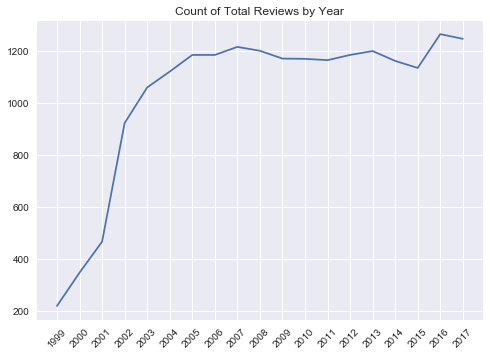

In [32]:
plt.title('Count of Total Reviews by Year')
plt.plot(df.groupby('pub_year').count()['reviewid'])
plt.xticks(range(1999,2018), rotation=45)
plt.show()

Pitchfork's "Best New Music" designation was introduced in 2003. Since 2009, Pitchfork labels between 80 and 100 albums as Best New Music.


#### TODO: Add Best New Reissue

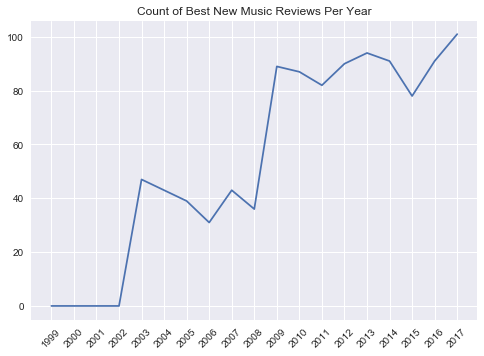

In [30]:
plt.plot(df.groupby('pub_year').sum()['best_new_music'])
plt.title("Count of Best New Music Reviews Per Year")
plt.xticks(range(1999,2018), rotation=45)
plt.show()

Best New Music albums usually receive a score of 8.3 or higher, though this is not a hard-and-fast rule.

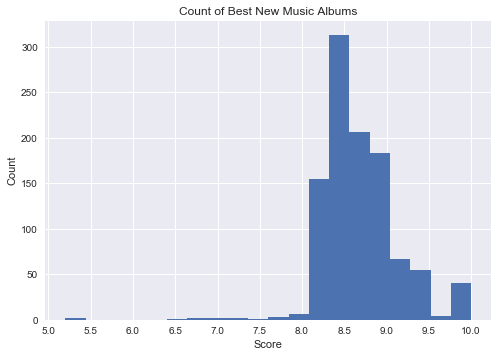

In [42]:
plt.hist(df[df['best_new_music'] == 1]['score'], bins=20)
plt.title('Count of Best New Music Albums')
plt.xticks(np.arange(5,10.5,.5))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Distribution of Scores

The overall distribution of scores (for all albums on Pitchfork) is left skewed with a mean of 7.03. There is some expected selection bias, where Pitchfork generally reviews albums that are good enough for its readers to consume. Reviews with very low scores are either released by notable artists, or are written for entertainment value.

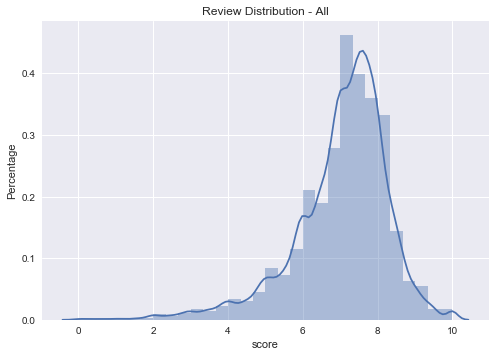

Overall Mean: 7.02726994803


In [43]:
sns.distplot(df['score'], bins=30)
plt.title("Review Distribution - All")
plt.ylabel('Percentage')
plt.show()

print "Overall Mean:", df['score'].mean()

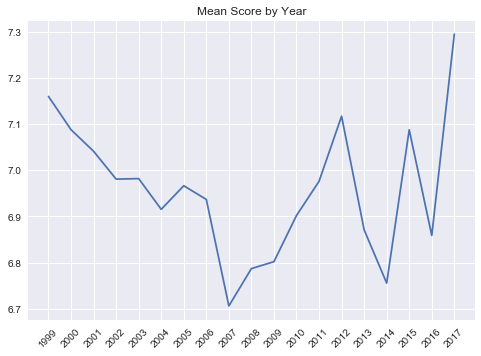

In [44]:
plt.plot(df_new['pub_year'].unique(), df_new.groupby('pub_year')['score'].mean())
plt.title('Mean Score by Year')
plt.xticks(range(1999, 2018), rotation=45)
plt.show()

The yearly mean score gradually decreased from 1999 to 2007, gradually increased from 2007 to 2012, and has fluctuated greatly since then. This could be due to editorial inflation/deflation, or natural fluctuation in the quality of music released year over year.

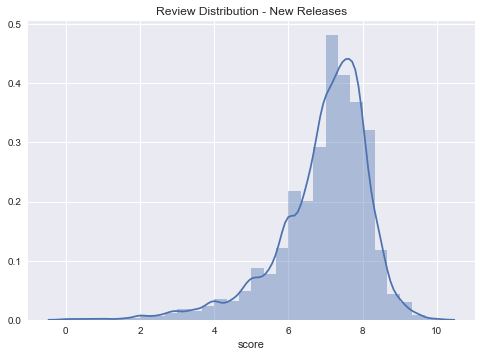

In [37]:
plt.title("Review Distribution - New Releases")
sns.distplot(df_new['score'], bins=30)
plt.show()

## The distribution of scores given has shrunk over the past several years 

In [45]:
df_new[(df_new['score'] <= 3) & (df_new['pub_year'] > 2012)]
pass

In [46]:
years = np.arange(1999, 2018)
less3 = list(df_new[df_new['score'] <= 3].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
less6 = list(df_new[df_new['score'] <= 6].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
more9 = list(df_new[df_new['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
reis_more9 = list(df_reissue[df_reissue['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_reissue.groupby('pub_year')['reviewid'].count().astype(float)))

Pitchfork has sharply decreased its frequency of giving scathing reviews

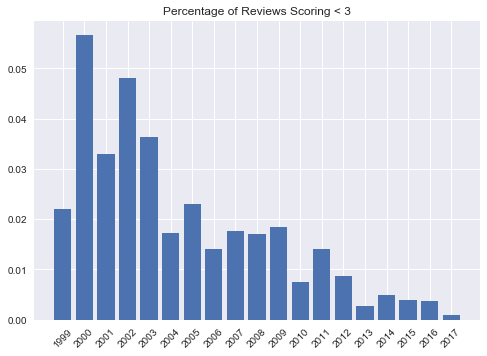

In [47]:
plt.bar(years, less3)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 3")
plt.show()

It's becoming more rare to see albums scoring below a 6. Nearly 90% of reviews in 2017 were 6+.

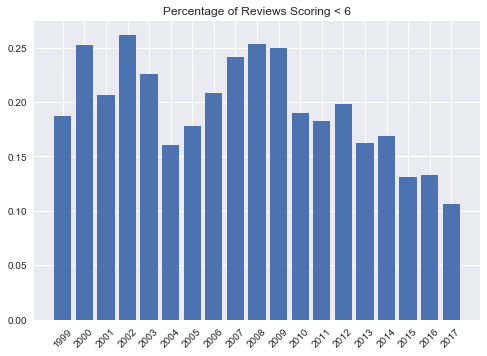

In [48]:
plt.bar(years, less6)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 6")

plt.show()

Albums scoring above 9 are still a rare commodity

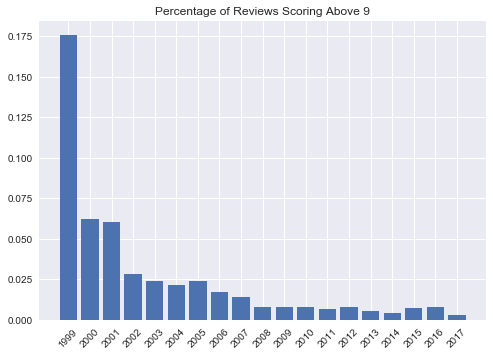

In [49]:
plt.bar(years, more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring Above 9")

plt.show()

...Except in the case of classic albums and reissues.

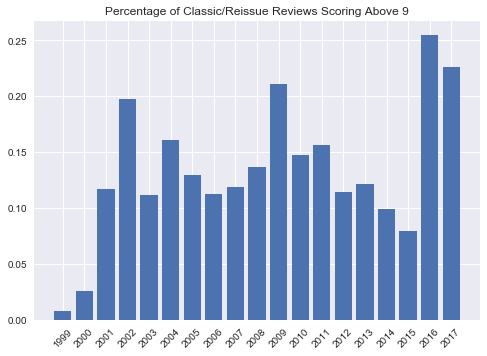

In [50]:
plt.bar(years, reis_more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Classic/Reissue Reviews Scoring Above 9")

plt.show()

The lower boundary of the range for reviews is rising. There hasn't been an album with a score lower than 2 since 2013.

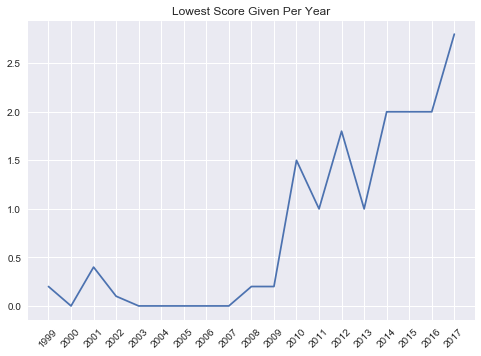

In [53]:
plt.plot(df.groupby('pub_year')['score'].min())
plt.xticks(np.arange(1999,2018), rotation=45)
plt.yticks(np.arange(0,3,.5), np.arange(0,3,.5))
plt.title("Lowest Score Given Per Year")
plt.show()

The distribution of reviews is getting narrower year over year.

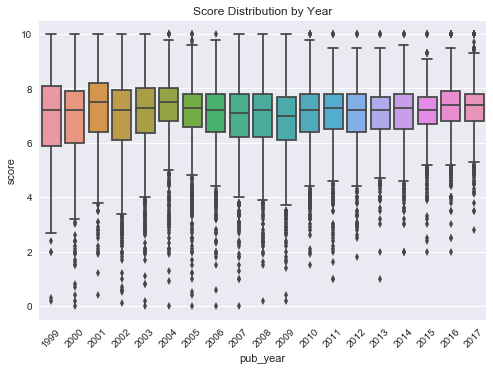

In [76]:
sns.boxplot(x=df['pub_year'], y=df['score'], data=df[['score', 'pub_year']])
plt.title('Score Distribution by Year')
plt.xticks(rotation=45)
plt.show()

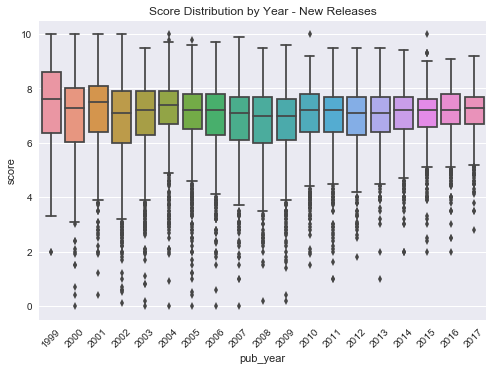

In [78]:
sns.boxplot(x=df_new['pub_year'], y=df_new['score'], data=df_new[['score', 'pub_year']])
plt.title('Score Distribution by Year - New Releases')
plt.xticks(rotation=45)
plt.show()

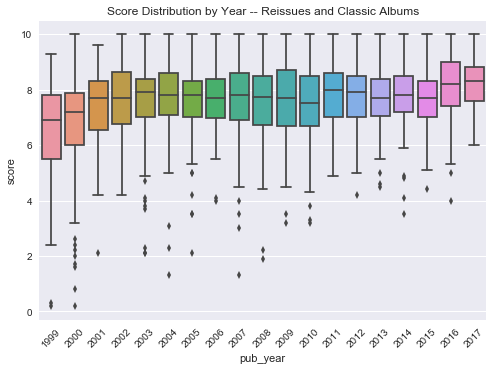

In [80]:
sns.boxplot(x=df_reissue['pub_year'], y=df_reissue['score'], data=df_reissue[['score', 'pub_year']])
plt.title("Score Distribution by Year -- Reissues and Classic Albums")
plt.xticks(rotation=45)
plt.show()

In [83]:
# score_by_year = df_new.groupby('pub_year').agg(['mean', 'max','min','count','sum']).reset_index()

# score_by_year['percent_bnm'] = score_by_year['best_new_music']['sum'] / score_by_year['score']['count']

# plt.plot(score_by_year['pub_year'][4:19], score_by_year['percent_bnm'][4:19])
# plt.title('Best New Music Frequency')
# plt.xticks(score_by_year['pub_year'][4:19], rotation=45)
# plt.yticks()
# plt.xlabel('Year')
# plt.ylabel('% of Albums Named Best New Music')
# plt.show()

# Basic NLP

I'm using TextBlob to measure the polarity and subjectivity of each review. Polarity is a score between [-1, 1] measuring positivity of text, and subjectivity is a score between [0, 1] where scores closer to 1 are more subjective.

In [84]:
df.groupby('pub_year')['subjectivity'].mean()

pub_year
1999    0.496662
2000    0.494536
2001    0.490549
2002    0.489181
2003    0.490955
2004    0.489266
2005    0.482939
2006    0.482694
2007    0.478644
2008    0.477968
2009    0.479418
2010    0.479706
2011    0.475365
2012    0.476567
2013    0.474036
2014    0.470587
2015    0.469726
2016    0.467457
2017    0.466372
Name: subjectivity, dtype: float64

Average subjectivity of reviews has gone down year over year. Authors are becoming more objective, using language that is less opinion-based.

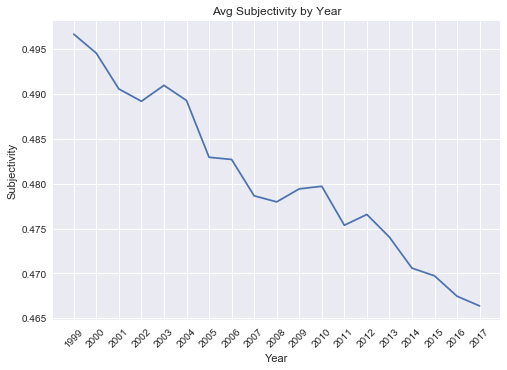

In [85]:
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['subjectivity'].mean())
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('Avg Subjectivity by Year')
plt.show()

In [98]:
df['score_bin'] = (df['score'] // 1).astype(int)

def plot_subj_violins_score(df, genre='all genres'):
    scores = list(df.score_bin.unique())
    pol_dist = {1: [],}
    for pol,score in zip(df.subjectivity.astype(list), df.score_bin.astype(list)):
        if score not in pol_dist.keys():
            pol_dist[score] = []
        else:
            pol_dist[score] = pol_dist[score] + [pol]

    plt.figure(figsize=(30,14))
#     plt.hlines(df['subjectivity'].mean(), 0, 10, linestyles='dotted')
    for each in scores:
        plt.xticks(range(0,11), fontsize=16)
        plt.violinplot(np.array(pol_dist[each]), [each], widths=1,showmedians=True,showextrema=True)
    plt.title('Subjectivity Distribution by Score ({})'.format(genre), fontsize=24)
    plt.ylabel('Subjectivity', fontsize=16)
    plt.xlabel('Binned Score', fontsize=16)

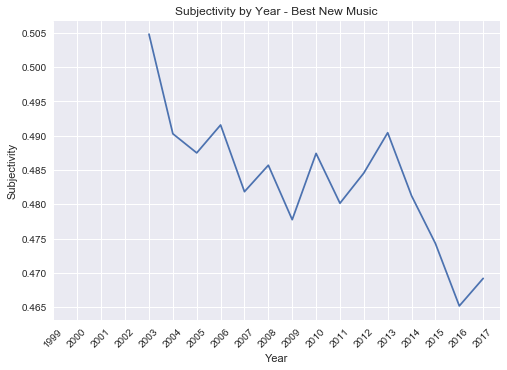

In [99]:
df_bnm = df_new[df_new['best_new_music'] == 1]
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['subjectivity'].mean())
plt.xticks(years, rotation=45)
plt.title('Subjectivity by Year - Best New Music')
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
sns.boxplot(x=dfdf['pub_year'], y=df['subjectivity'], data=df[['score', 'subjectivity']])
plt.ylim(.28, .7)
plt.title("Subjectivity Distribution by Year -- All Albums")
plt.xticks(rotation=45)
plt.show()

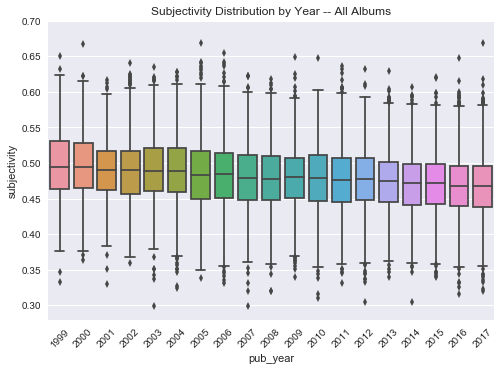

In [96]:
sns.boxplot(x=df['pub_year'], y=df['subjectivity'], data=df[['score', 'subjectivity']])
plt.ylim(.28, .7)
plt.title("Subjectivity Distribution by Year -- All Albums")
plt.xticks(rotation=45)
plt.show()

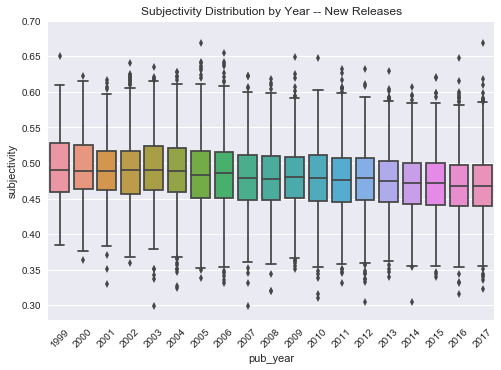

In [97]:
sns.boxplot(x=df_new['pub_year'], y=df_new['subjectivity'], data=df_new[['score', 'subjectivity']])
plt.title("Subjectivity Distribution by Year -- New Releases")
plt.ylim(.28, .7)
plt.xticks(rotation=45)
plt.show()

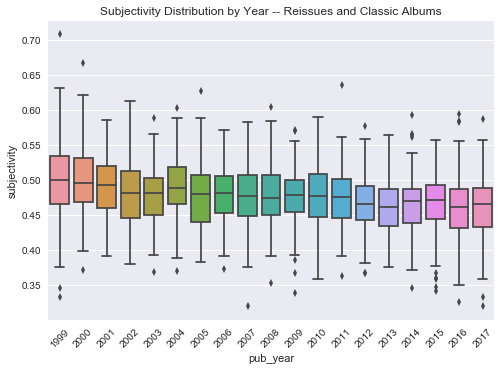

In [87]:
sns.boxplot(x=df_reissue['pub_year'], y=df_reissue['subjectivity'], data=df_reissue[['score', 'subjectivity']])
plt.title("Subjectivity Distribution by Year -- Reissues and Classic Albums")
plt.xticks(rotation=45)
plt.show()

## Simple Linear Regression Using Subjectivity/Polarity

In [ ]:
plt.scatter(df_new['polarity'], df_new['score'])
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
Y = df['score']
X = df[['polarity', 'pub_year', 'new_album', 'genre_rock']]
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
results.summary()